# Individual Database Analysis Report

**Project:** Digital Teotihuacan Mapping Project (TMP) - Phase 1

**Objective:** This notebook provides a comprehensive analysis of a single legacy or benchmark database. It loads the raw metric files generated by the `02_run_profiling_pipeline.py` script and produces a series of tables and visualizations to assess the database's structure, health, data content, and performance.

**Instructions:**
1.  **Set the `DATABASE_NAME`** in the configuration cell below.
2.  **Execute all cells** from top to bottom (`Kernel > Restart & Run All`).
3.  **Review the outputs** and complete the **Analyst Summary** section at the end.

--- 
## 1. Setup and Configuration

In [12]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display, Markdown, SVG
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- CONFIGURATION ---------------------------------------------------
# SET THIS VARIABLE to the name of the database you want to analyze.
# e.g., 'tmp_df8', 'tmp_df9', 'tmp_benchmark_wide_numeric', etc.
DATABASE_NAME = "tmp_benchmark_wide_numeric" # <--- CHANGE THIS
# ---------------------------------------------------------------------

# --- Path Definitions ---
# Use relative paths from the notebook's location in reports/individual_db_analysis/
METRICS_DIR = Path("../../outputs/metrics")
ERDS_DIR = Path("../../outputs/erds")

# --- Styling and Display Options ---
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

def display_header(title):
    display(Markdown(f'### {title}'))

def load_metric_file(metric_name, file_type='csv'):
    """Helper function to safely load a metric file."""
    file_path = METRICS_DIR / f"{DATABASE_NAME}_{metric_name}.{file_type}"
    if not file_path.exists():
        print(f"⚠️ WARNING: Metric file not found: {file_path.name}")
        return None
    if file_type == 'csv':
        return pd.read_csv(file_path)
    elif file_type == 'json':
        with open(file_path, 'r') as f:
            return json.load(f)

print(f"✅ Setup complete. Analyzing database: '{DATABASE_NAME}'")
print(f"Metrics Directory: {METRICS_DIR}")
print(f"ERD Directory: {ERDS_DIR}")

✅ Setup complete. Analyzing database: 'tmp_benchmark_wide_numeric'
Metrics Directory: ..\..\outputs\metrics
ERD Directory: ..\..\outputs\erds


--- 
## 2. Data Loading
Load all available metric files for the selected database. Warnings will be printed for any missing files.

In [13]:
# Load all metric files into variables
basic_metrics = load_metric_file('basic_metrics', 'json')
schema_counts = load_metric_file('schema_counts', 'json')
# Note: interop_metrics file doesn't exist for benchmark databases
interop_metrics = None

# Load table metrics and convert to DataFrame
table_metrics_data = load_metric_file('table_metrics', 'json')
table_metrics_df = pd.DataFrame(table_metrics_data) if table_metrics_data else None

# Load column structure and convert to DataFrame
column_structure_data = load_metric_file('column_structure', 'json')
column_structure_df = pd.DataFrame(column_structure_data) if column_structure_data else None

# Load column profiles and convert to DataFrame
column_profiles_data = load_metric_file('column_profiles', 'json')
column_profiles_df = pd.DataFrame(column_profiles_data) if column_profiles_data else None

# Performance benchmarks remain as CSV
performance_df = load_metric_file('performance_benchmarks')

print("✅ Data loading complete.")

✅ Data loading complete.


--- 
## 3. High-Level Overview & Schema Visualization

In [14]:
display_header(f"Key Metrics for: {DATABASE_NAME}")

summary_data = {}
if basic_metrics: summary_data.update(basic_metrics)
if schema_counts: summary_data.update(schema_counts)
if interop_metrics: summary_data.update(interop_metrics)
if table_metrics_df is not None:
    summary_data['total_estimated_rows'] = int(table_metrics_df['row_estimate'].sum())

if summary_data:
    summary_series = pd.Series(summary_data).rename('Value').to_frame()
    display(summary_series)
else:
    print("No summary metrics available.")

### Key Metrics for: tmp_benchmark_wide_numeric

,Value
database_name,tmp_benchmark_wide_numeric
database_size_mb,21
schema_name,public
table_count,1
view_count,0
function_count,0
sequence_count,0
total_estimated_rows,5050


### Entity-Relationship Diagram (ERD)
The following diagram shows the full relational structure of the database schema. For complex schemas like `tmp_df9`, this may be very large and focused ERDs should be consulted.

### Full ERD for: tmp_benchmark_wide_numeric

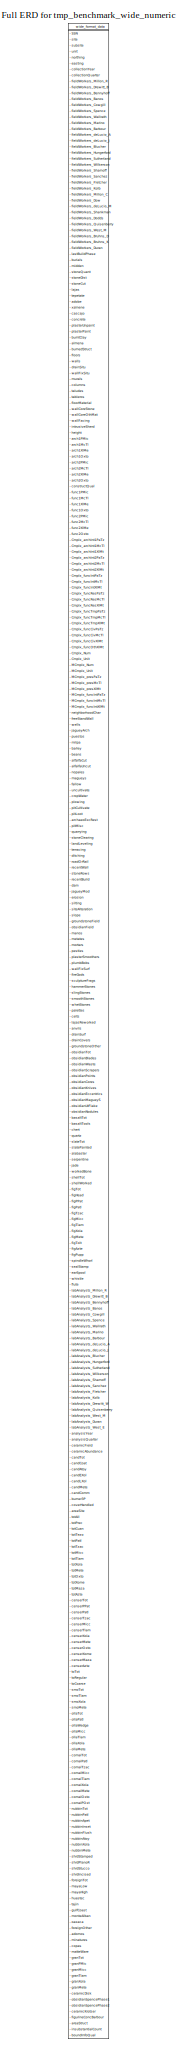

In [15]:
display_header(f"Full ERD for: {DATABASE_NAME}")

try:
    # Find the most recent ERD file for the database
    erd_files = sorted(ERDS_DIR.glob(f"{DATABASE_NAME}_full_ERD_*.svg"), reverse=True)
    if erd_files:
        display(SVG(erd_files[0]))
    else:
        print(f"❌ ERROR: Full ERD SVG file not found for '{DATABASE_NAME}'.")
except Exception as e:
    print(f"An error occurred while displaying the ERD: {e}")

--- 
## 4. Table-Level Analysis
Analysis of the tables within the schema, focusing on size, row count, and health (bloat).

In [16]:
display_header("Table Metrics Summary")

if table_metrics_df is not None and not table_metrics_df.empty:
    display(table_metrics_df.sort_values(by='row_estimate', ascending=False).style.background_gradient(cmap='viridis', subset=['row_estimate', 'bloat_percent']))
else:
    print("No table metrics data available.")

### Table Metrics Summary

,table_name,row_estimate,column_count,table_size,index_size,total_size,index_count,bloat_bytes,bloat_percent,bloat_size
0,wide_format_data,5050,337,13 MB,0 bytes,13 MB,0,157144.663644,1.140000,0.15 MB


In [17]:
display_header("Largest Tables by Total Size and Bloat")

if table_metrics_df is not None and not table_metrics_df.empty:
    # Convert pretty size string to bytes for sorting
    def size_to_bytes(s):
        if not isinstance(s, str): return 0
        num, unit = s.split()
        num = float(num)
        if 'KB' in unit: return num * 1024
        if 'MB' in unit: return num * 1024**2
        if 'GB' in unit: return num * 1024**3
        return num
    
    df_copy = table_metrics_df.copy()
    df_copy['total_bytes'] = df_copy['total_size'].apply(size_to_bytes)
    df_copy['bloat_bytes_val'] = df_copy['bloat_bytes']

    top_10_size = df_copy.nlargest(10, 'total_bytes')
    top_10_bloat = df_copy.nlargest(10, 'bloat_bytes_val')

    # Display tables
    display(Markdown("**Top 10 Tables by Total Size**"))
    display(top_10_size[['table_name', 'total_size', 'row_estimate']].reset_index(drop=True))
    
    display(Markdown("**Top 10 Tables by Bloat Size**"))
    display(top_10_bloat[['table_name', 'bloat_size', 'bloat_percent', 'row_estimate']].reset_index(drop=True))

    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Top 10 Tables by Total Size", "Top 10 Tables by Bloat Size")
    )

    fig.add_trace(go.Bar(y=top_10_size['table_name'], x=top_10_size['total_bytes'], orientation='h', name='Total Size'), row=1, col=1)
    fig.add_trace(go.Bar(y=top_10_bloat['table_name'], x=top_10_bloat['bloat_bytes_val'], orientation='h', name='Bloat Size'), row=1, col=2)
    
    fig.update_layout(title_text=f'Table Size Analysis for {DATABASE_NAME}', height=500, showlegend=False)
    fig.update_yaxes(autorange="reversed")
    fig.update_xaxes(title_text="Size (Bytes)", row=1, col=1)
    fig.update_xaxes(title_text="Bloat (Bytes)", row=1, col=2)
    fig.show()
else:
    print("No table metrics data available for plotting.")

### Largest Tables by Total Size and Bloat

**Top 10 Tables by Total Size**

,table_name,total_size,row_estimate
0,wide_format_data,13 MB,5050


**Top 10 Tables by Bloat Size**

,table_name,bloat_size,bloat_percent,row_estimate
0,wide_format_data,0.15 MB,1.14,5050


--- 
## 5. Column-Level Analysis
A deep dive into the columns, focusing on data types, data completeness (NULL values), and complexity (cardinality).

In [18]:
display_header("Data Type Distribution")

if column_structure_df is not None:
    type_counts = column_structure_df['data_type'].value_counts().reset_index()
    type_counts.columns = ['data_type', 'count']
    
    # Calculate percentages
    type_counts['percentage'] = (type_counts['count'] / type_counts['count'].sum() * 100).round(2)
    
    # Display comprehensive table
    display(Markdown("**Complete Data Type Distribution**"))
    display(type_counts.style.format({'percentage': '{:.2f}%'}))
    
    # Display summary statistics
    display(Markdown("**Data Type Summary**"))
    summary_stats = pd.DataFrame({
        'Total Columns': [type_counts['count'].sum()],
        'Unique Data Types': [len(type_counts)],
        'Most Common Type': [f"{type_counts.iloc[0]['data_type']} ({type_counts.iloc[0]['count']} columns)"],
        'Least Common Type': [f"{type_counts.iloc[-1]['data_type']} ({type_counts.iloc[-1]['count']} columns)"]
    })
    display(summary_stats)
    
    fig = px.bar(type_counts, x='data_type', y='count', title=f'Column Data Type Frequencies in {DATABASE_NAME}',
                 labels={'count': 'Number of Columns', 'data_type': 'Data Type'})
    fig.show()
else:
    print("No column structure data available.")

### Data Type Distribution

**Complete Data Type Distribution**

,data_type,count,percentage
0,bigint,279,82.79%
1,boolean,53,15.73%
2,text,5,1.48%


**Data Type Summary**

,Total Columns,Unique Data Types,Most Common Type,Least Common Type
0,337,3,bigint (279 columns),text (5 columns)


### Data Completeness: NULL Value Analysis

In [19]:
display_header("Top 20 Columns by Percentage of NULL Values")

if column_profiles_df is not None and not column_profiles_df.empty:
    # Ensure we only show columns with NULLs
    null_df = column_profiles_df[column_profiles_df['null_percent'] > 0].copy()
    
    if not null_df.empty:
        # Create a full column identifier for clarity
        null_df['full_column_name'] = null_df['tablename'] + '.' + null_df['column_name']
        
        top_20_nulls = null_df.nlargest(20, 'null_percent')
        
        # Display table
        display(Markdown("**Top 20 Columns with Highest NULL Percentages**"))
        table_display = top_20_nulls[['full_column_name', 'null_percent', 'null_count_estimate', 'row_count_exact']].copy()
        table_display.columns = ['Column', 'NULL %', 'NULL Count', 'Total Rows']
        display(table_display.reset_index(drop=True))
        
        # Display summary statistics
        display(Markdown("**NULL Value Summary**"))
        null_summary = pd.DataFrame({
            'Total Columns Analyzed': [len(column_profiles_df)],
            'Columns with NULLs': [len(null_df)],
            'Columns with 100% NULLs': [len(null_df[null_df['null_percent'] == 100])],
            'Average NULL %': [f"{null_df['null_percent'].mean():.2f}%"],
            'Median NULL %': [f"{null_df['null_percent'].median():.2f}%"]
        })
        display(null_summary)
        
        fig = px.bar(top_20_nulls, 
                     y='full_column_name', 
                     x='null_percent', 
                     orientation='h',
                     title=f'Top 20 Columns by NULL Percentage in {DATABASE_NAME}',
                     labels={'null_percent': 'Percentage of Rows that are NULL (%)', 'full_column_name': 'Column'})
        fig.update_layout(height=600)
        fig.update_yaxes(autorange="reversed")
        fig.show()
    else:
        print("✅ Excellent! No columns with NULL values were found.")
        
        # Still show summary even when no NULLs
        display(Markdown("**NULL Value Summary**"))
        null_summary = pd.DataFrame({
            'Total Columns Analyzed': [len(column_profiles_df)],
            'Columns with NULLs': [0],
            'Data Completeness': ['100% - Perfect!']
        })
        display(null_summary)
else:
    print("No column profile data available.")

### Top 20 Columns by Percentage of NULL Values

✅ Excellent! No columns with NULL values were found.


**NULL Value Summary**

,Total Columns Analyzed,Columns with NULLs,Data Completeness
0,337,0,100% - Perfect!


### Data Complexity: Cardinality Analysis
Cardinality refers to the number of unique values in a column. 

- **Low Cardinality** columns (e.g., < 20 unique values) are often categorical codes or flags.
- **High Cardinality** columns often represent unique identifiers or free-text fields.

In [20]:
display_header("Column Cardinality Distribution")

if column_profiles_df is not None and not column_profiles_df.empty:
    # Create a full column identifier
    df = column_profiles_df.copy()
    df['full_column_name'] = df['tablename'] + '.' + df['column_name']

    # Display tables of highest and lowest cardinality columns
    display(Markdown("**Columns with Highest Cardinality (Most Unique)**"))
    display(df.nlargest(10, 'distinct_values_estimate')[['full_column_name', 'distinct_values_estimate']])

    display(Markdown("**Columns with Lowest Cardinality (Least Unique)**"))
    display(df[df['distinct_values_estimate'] > 1].nsmallest(10, 'distinct_values_estimate')[['full_column_name', 'distinct_values_estimate']])
    
    # Create a histogram of cardinalities to see the distribution
    fig = px.histogram(df, x='distinct_values_estimate', log_y=True, 
                       title=f'Distribution of Column Cardinalities in {DATABASE_NAME}',
                       labels={'distinct_values_estimate': 'Number of Distinct Values (Cardinality)'})
    fig.show()
else:
    print("No column profile data available.")

### Column Cardinality Distribution

**Columns with Highest Cardinality (Most Unique)**

,full_column_name,distinct_values_estimate
171,wide_format_data.obsidianTot,386.0
256,wide_format_data.totTlam,233.0
173,wide_format_data.obsidianWaste,231.0
257,wide_format_data.totXola,221.0
6,wide_format_data.site,197.0
7,wide_format_data.subsite,195.0
254,wide_format_data.totTzac,193.0
172,wide_format_data.obsidianBlades,189.0
264,wide_format_data.totAzte,186.0
278,wide_format_data.toTot,181.0


**Columns with Lowest Cardinality (Least Unique)**

,full_column_name,distinct_values_estimate
0,wide_format_data.fieldWorkers_Hungerford,2.0
1,wide_format_data.fieldWorkers_Sutherland,2.0
2,wide_format_data.fieldWorkers_Wilkerson,2.0
3,wide_format_data.fieldWorkers_Sharnoff,2.0
4,wide_format_data.fieldWorkers_Sanchez,2.0
8,wide_format_data.fieldWorkers_Fletcher,2.0
9,wide_format_data.fieldWorkers_Kolb,2.0
10,wide_format_data.fieldWorkers_Millon_C,2.0
16,wide_format_data.fieldWorkers_Millon_R,2.0
17,wide_format_data.fieldWorkers_Drewitt_B,2.0


--- 
## 6. Performance Benchmark Analysis

In [21]:
display_header("Canonical Query Performance Results")

if performance_df is not None and not performance_df.empty:
    display(performance_df[['query_name', 'latency_ms', 'status']])
    
    # Plot the results for successful queries
    success_df = performance_df[performance_df['status'] == 'Success']
    if not success_df.empty:
        fig = px.bar(success_df, x='query_name', y='latency_ms',
                     title=f'Query Latency for {DATABASE_NAME}',
                     labels={'latency_ms': 'Latency (ms)', 'query_name': 'Canonical Query'})
        fig.show()
else:
    print("No performance benchmark data available.")

### Canonical Query Performance Results

,query_name,latency_ms,status
0,Baseline Performance - Query 1.1,1.4751,Success
1,Join_performance Performance - Query 2.1,12.0292,Success
2,Complex_filtering Performance - Query 3.1,2.4963,Success


---
## 7. Analyst Summary & Interpretation

**Instructions:** Based on the data and visualizations above, provide a concise summary of your findings for the **`{DATABASE_NAME}`** database. Address the following points.

### Key Observations:
* *Your summary of the most striking features of this database. What is its primary characteristic (e.g., highly normalized, a few very large tables, excellent data completeness)?*

### Data Quality & Health Concerns:
* *Comment on the prevalence of NULL values. Are they concentrated in specific tables or columns? What might this imply about data collection or relevance?*
* *Discuss the database bloat. Are there specific tables that are heavily bloated and may require maintenance (e.g., `VACUUM FULL`)?*

### Structural Complexity:
* *Analyze the relational structure based on the ERD and interoperability metrics (if applicable). Is the schema simple or complex? How does this relate to its JDI/NF score?*
* *Discuss the data type usage. Is it appropriate for the data being stored?*

### Performance Profile:
* *Summarize the performance benchmark results. Were queries generally fast or slow? Were there any specific queries that were outliers?*

### Implications for Phase 2 Redesign:
* *Based on this analysis, what are the key strengths and weaknesses of this database's design?*
* *What specific aspects of this schema should be preserved, changed, or discarded in the final unified database? (e.g., "The high number of tables needs to be consolidated," or "The use of boolean flags is effective and should be maintained.")*